In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import gc
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    from keras import models
    from keras import layers
    from keras import metrics
    from keras.callbacks import EarlyStopping

2023-12-02 18:43:43.669434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
def read_and_prepare_data(validation_mode, k=5, augment=True):

    if validation_mode == 'k_fold':

        # Read in data from files
        images = np.load('images.npy')
        labels = np.load('labels.npy')

        # Split the image and label datasets into k number of subsets
        folded_images = []
        folded_labels = []
        for i in range(k):
            start = int((i / k) * len(images))
            end = int(((i + 1) / k) * len(images))
            folded_images.append(images[start:end])
            folded_labels.append(labels[start:end])

        # Generate augmented images for each fold
        folded_augmented_images = []
        folded_augmented_labels = []
        for i in range(k):
            if augment:
                print('\nAugmenting Fold ' + str(i + 1) + ' of ' + str(k))
                augmented_images, augmented_labels = augment_images(folded_images[i], folded_labels[i])
                folded_augmented_images.append(augmented_images)
                folded_augmented_labels.append(augmented_labels)


        # Combine the folds into sets for each iteration of the model and standardize the data
        train_images = []
        train_labels = []
        test_images = []
        test_labels = []
        for i in range(k):
            train_images.append(np.concatenate(folded_images[:i] + folded_images[(i+1):]))
            train_labels.append(np.concatenate(folded_labels[:i] + folded_labels[(i+1):]))
            if augment:
                train_images[i] = np.concatenate(([train_images[i]] + folded_augmented_images[:i] + folded_augmented_images[(i + 1):]))
                train_labels[i] = np.concatenate(([train_labels[i]] + folded_augmented_labels[:i] + folded_augmented_labels[(i + 1):]))
            test_images.append(folded_images[i])
            test_labels.append(folded_labels[i])
            train_images[i], test_images[i] = standardize_data(train_images[i], test_images[i])

        return train_images, train_labels, test_images, test_labels


def augment_images(images, labels):

    # Create generators to augment images
    from keras.preprocessing import image
    flip_generator = image.ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True
    )
    rotate_generator = image.ImageDataGenerator(
        rotation_range=360,
        fill_mode='nearest'
    )

    # Accumulate augmented images and labels
    augmented_images = []
    augmented_labels = []

    # Loop each images in the set to augment
    for i in range(len(images)):

        # Reshape image for generator
        image = np.reshape(images[i], (1, images[i].shape[0], images[i].shape[1], 1))
        label = labels[i]

        # Reset the number of augmented images have been created to zero
        num_new_images = 0

        # Generate 2 new images if the image is of a tropical cyclone between 50 and 75 knots
        if 50 < label < 75:
            for batch in flip_generator.flow(image, batch_size=1):
                gc.collect()
                new_image = np.reshape(batch[0], (batch[0].shape[0], batch[0].shape[1], 1))
                augmented_images.append(new_image)
                augmented_labels.append(label)
                num_new_images += 1
                if num_new_images == 2:
                    break

        # Generate 6 new images if the image is of a tropical cyclone between 75 and 100 knots
        elif 75 < label < 100:
            for batch in rotate_generator.flow(image, batch_size=1):
                gc.collect()
                new_image = np.reshape(batch[0], (batch[0].shape[0], batch[0].shape[1], 1))
                augmented_images.append(new_image)
                augmented_labels.append(label)
                num_new_images += 1
                if num_new_images == 6:
                    break

        # Generate 12 new images if the image is of a tropical cyclone greater than or equal to 100 knots
        elif 100 <= label:
            for batch in rotate_generator.flow(image, batch_size=1):
                gc.collect()
                new_image = np.reshape(batch[0], (batch[0].shape[0], batch[0].shape[1], 1))
                augmented_images.append(new_image)
                augmented_labels.append(label)
                num_new_images += 1
                if num_new_images == 12:
                    break

        print_progress('Augmenting Images', i + 1, len(images))

    # Convert lists of images/labels into numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_labels


def build_model():

    # Build network architecture
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation=None))

    # Configure model optimization
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

    return model


def train_model(model, train_images, train_labels, test_images, test_labels, show_performance_by_epoch=False):

    # Run model and get metrics for each epoch
    performance_log = model.fit(
        train_images,
        train_labels,
        callbacks=[EarlyStopping(monitor='val_mean_absolute_error', patience=15, restore_best_weights=True)],
        epochs=100,
        batch_size=64,
        validation_data=(test_images, test_labels),
        shuffle = True)

    if show_performance_by_epoch:
        performance_by_epoch(performance_log)

    return model


def performance_by_epoch(performance_log):

    # Get metrics for each epoch after model finishes training
    train_loss = performance_log.history['loss']
    test_loss = performance_log.history['val_loss']
    train_mae = performance_log.history['mean_absolute_error']
    test_mae = performance_log.history['val_mean_absolute_error']
    epochs = range(1, len(train_loss) + 1)

    # Build a dataframe storing epoch metrics
    performance_df = pd.DataFrame(columns=['epoch', 'train_or_test', 'loss_or_mae', 'value'])
    for i in range(len(train_loss)):
        new_row = {'epoch': epochs[i], 'train_or_test': 'train', 'loss_or_mae': 'loss', 'value': train_loss[i]}
        performance_df = performance_df.append(new_row, ignore_index=True)
        new_row = {'epoch': epochs[i], 'train_or_test': 'test', 'loss_or_mae': 'loss', 'value': test_loss[i]}
        performance_df = performance_df.append(new_row, ignore_index=True)
        new_row = {'epoch': epochs[i], 'train_or_test': 'train', 'loss_or_mae': 'mae', 'value': train_mae[i]}
        performance_df = performance_df.append(new_row, ignore_index=True)
        new_row = {'epoch': epochs[i], 'train_or_test': 'test', 'loss_or_mae': 'mae', 'value': test_mae[i]}
        performance_df = performance_df.append(new_row, ignore_index=True)
    performance_df = performance_df.astype({'epoch': np.int64})

    # Plot metrics on graph, fitted with exponential decay curves
    lm = sns.lmplot(
        x='epoch',
        y='value',
        data=performance_df,
        row='loss_or_mae',
        hue='train_or_test',  # Note: If epoch = 1, this line causes an error. Make sure epoch >= 2
        logx=True,
        truncate=False,
        sharey=False)
    axes = lm.axes
    max_mae = performance_df.loc[performance_df.loss_or_mae == 'mae']['value'].max()
    min_mae = performance_df.loc[performance_df.loss_or_mae == 'mae']['value'].min()
    axes[1, 0].set_ylim(min_mae - min_mae * 0.2, max_mae + max_mae * 0.2)
    plt.show()


def generate_predictions(model, test_images, test_labels):

    # Run validation data through model and print mean absolute error
    raw_predictions = model.predict(test_images)
    raw_predictions = raw_predictions.flatten()

    # Build a dataframe storing data for each prediction made by the model
    processed_predictions = pd.DataFrame(columns=['prediction', 'actual', 'abs_error', 'category'])
    for i in range(len(raw_predictions)):
        abs_error = abs(raw_predictions[i] - test_labels[i])
        new_row = {
            'prediction': raw_predictions[i],
            'actual': test_labels[i],
            'abs_error': abs_error,
            'abs_error_squared': abs_error ** 2,
            'category': category_of(test_labels[i])}
        processed_predictions = pd.concat([processed_predictions, pd.DataFrame([new_row])],ignore_index=True)
        # processed_predictions = processed_predictions.concat(new_row, ignore_index=True)
        print_progress('Processing Predictions', i + 1, len(raw_predictions))

    return processed_predictions


def show_validation_results(predictions, show_plots=True, print_error=True):

    print('\n\nRESULTS')

    if print_error:
        mae = predictions['abs_error'].mean()
        print('\nMean Absolute Error: ' + str(round(float(mae), 2)) + ' knots')
        rmse = predictions['abs_error_squared'].mean() ** 0.5
        print('Root Mean Square Error: ' + str(round(float(rmse), 2)) + ' knots')

    if show_plots:
        # List of categories in order of ascending strength
        categories = ['T. Depression', 'T. Storm', 'Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']

        # Show bar graph of median absolute error for each category
        plt.figure(figsize=(10, 5), dpi=300)
        sns.barplot(
            x='category',
            y='abs_error',
            data=predictions,
            estimator=np.median,
            order=categories)
        sns.despine()
        plt.xlabel("Hurricane Strength")
        plt.ylabel("Absolute Error")
        plt.title("Median Absolute Error in Neural Network's Predictions By Category")
        plt.savefig('median_abs_error_by_category.png')
        print('Graph of median absolute error by category saved as median_abs_error_by_category.png')
        plt.clf()

        # Show density plot of error for each category
        for category in categories:
            num_samples_tested = len(predictions.loc[predictions.category == category]['abs_error'])
            sns.distplot(
                predictions.loc[predictions.category == category]['abs_error'],
                label=category + ' (' + str(num_samples_tested) + ' samples tested)',
                hist=False,
                kde_kws={"shade": True})
            sns.despine()
        plt.xlabel("Absolute Error")
        plt.title("Distribution of Absolute Error By Category")
        plt.legend()
        plt.xlim(0, None)
        plt.ylim(0, None)
        plt.savefig('error_dist_by_category.png')
        print('Graph of error distribution by category saved as error_dist_by_category.png')


def standardize_data(train_images, test_images):
    train_images[train_images < 0] = 0
    test_images[test_images < 0] = 0
    st_dev = np.std(train_images)
    mean = np.mean(train_images)
    train_images = np.divide(np.subtract(train_images, mean), st_dev)
    test_images = np.divide(np.subtract(test_images, mean), st_dev)
    return train_images, test_images


def print_progress(action, progress, total):
    percent_progress = round((progress / total) * 100, 1)
    print('\r' + action + '... ' + str(percent_progress) + '% (' + str(progress) + ' of ' + str(total) + ')', end='')


def category_of(wind_speed):
    if wind_speed <= 33:
        return 'T. Depression'
    elif wind_speed <= 64:
        return 'T. Storm'
    elif wind_speed <= 83:
        return 'Category 1'
    elif wind_speed <= 95:
        return 'Category 2'
    elif wind_speed <= 113:
        return 'Category 3'
    elif wind_speed <= 134:
        return 'Category 4'
    else:
        return 'Category 5'


def evaluate_and_save(model,num_of_fold,x_test,y_test):
    # Evaluate
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0],'Test MAE:', score[1],'Test RMSE:', score[2])
    Loss.append(score[0])
    MAE.append(score[1])
    RMSE.append(score[2])
    print("save score...")

    # Save model
    output_name = str(num_of_fold + 1) + "_fold_model.h5"
    model.save(output_name)
    print("Saved:",output_name)


Augmenting Fold 1 of 2
Augmenting Images... 100.0% (495 of 495)
Augmenting Fold 2 of 2
Augmenting Images... 100.0% (495 of 495)

Training Fold 1 of 2

Epoch 1/10
18/18 [==============================] - 9s 391ms/step - loss: 1995.2075 - mean_absolute_error: 36.2162 - root_mean_squared_error: 44.6677 - val_loss: 1806.9215 - val_mean_absolute_error: 36.7454 - val_root_mean_squared_error: 42.5079
Epoch 2/10
18/18 [==============================] - 6s 362ms/step - loss: 450.0847 - mean_absolute_error: 16.7664 - root_mean_squared_error: 21.2152 - val_loss: 1196.6876 - val_mean_absolute_error: 30.0762 - val_root_mean_squared_error: 34.5932
Epoch 3/10
18/18 [==============================] - 7s 372ms/step - loss: 272.6017 - mean_absolute_error: 13.1667 - root_mean_squared_error: 16.5107 - val_loss: 860.6176 - val_mean_absolute_error: 24.5291 - val_root_mean_squared_error: 29.3363
Epoch 4/10
18/18 [==============================] - 6s 354ms/step - loss: 226.9938 - mean_absolute_error: 11.7559

/Users/opopligher1996/anaconda3/envs/DSME6756/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 1s 48ms/step
Processing Predictions... 100.0% (495 of 495)

Training Fold 2 of 2

Epoch 1/10
18/18 [==============================] - 6s 334ms/step - loss: 155.1706 - mean_absolute_error: 9.7576 - root_mean_squared_error: 12.4567 - val_loss: 330.3253 - val_mean_absolute_error: 13.7900 - val_root_mean_squared_error: 18.1749
Epoch 2/10
18/18 [==============================] - 6s 349ms/step - loss: 119.3117 - mean_absolute_error: 8.5468 - root_mean_squared_error: 10.9230 - val_loss: 412.7552 - val_mean_absolute_error: 15.3753 - val_root_mean_squared_error: 20.3164
Epoch 3/10
18/18 [==============================] - 6s 339ms/step - loss: 118.9893 - mean_absolute_error: 8.5155 - root_mean_squared_error: 10.9082 - val_loss: 316.7761 - val_mean_absolute_error: 13.8463 - val_root_mean_squared_error: 17.7982
Epoch 4/10
18/18 [==============================] - 5s 301ms/step - loss: 124.2485 - mean_absolute_error: 8.7583 - root_mean_squared_error: 11.1467 

/Users/opopligher1996/anaconda3/envs/DSME6756/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 1s 54ms/step
Processing Predictions... 100.0% (495 of 495)

RESULTS

Mean Absolute Error: 12.58 knots
Root Mean Square Error: 16.35 knots
Graph of median absolute error by category saved as median_abs_error_by_category.png


/var/folders/g6/yjkwxgqx3xn42nf4x5kcpmzw0000gn/T/ipykernel_44138/3239621823.py:256: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/Users/opopligher1996/anaconda3/envs/DSME6756/lib/python3.8/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/var/folders/g6/yjkwxgqx3xn42nf4x5kcpmzw0000gn/T/ipykernel_44138/3239621823.py:256: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt 

Graph of error distribution by category saved as error_dist_by_category.png
####### Fold 1 Result #######
Test loss: 302.29803466796875 Test MAE: 13.590485572814941 Test RMSE: 17.386720657348633
####### Fold 2 Result #######
Test loss: 232.4426727294922 Test MAE: 11.56601619720459 Test RMSE: 15.246070861816406


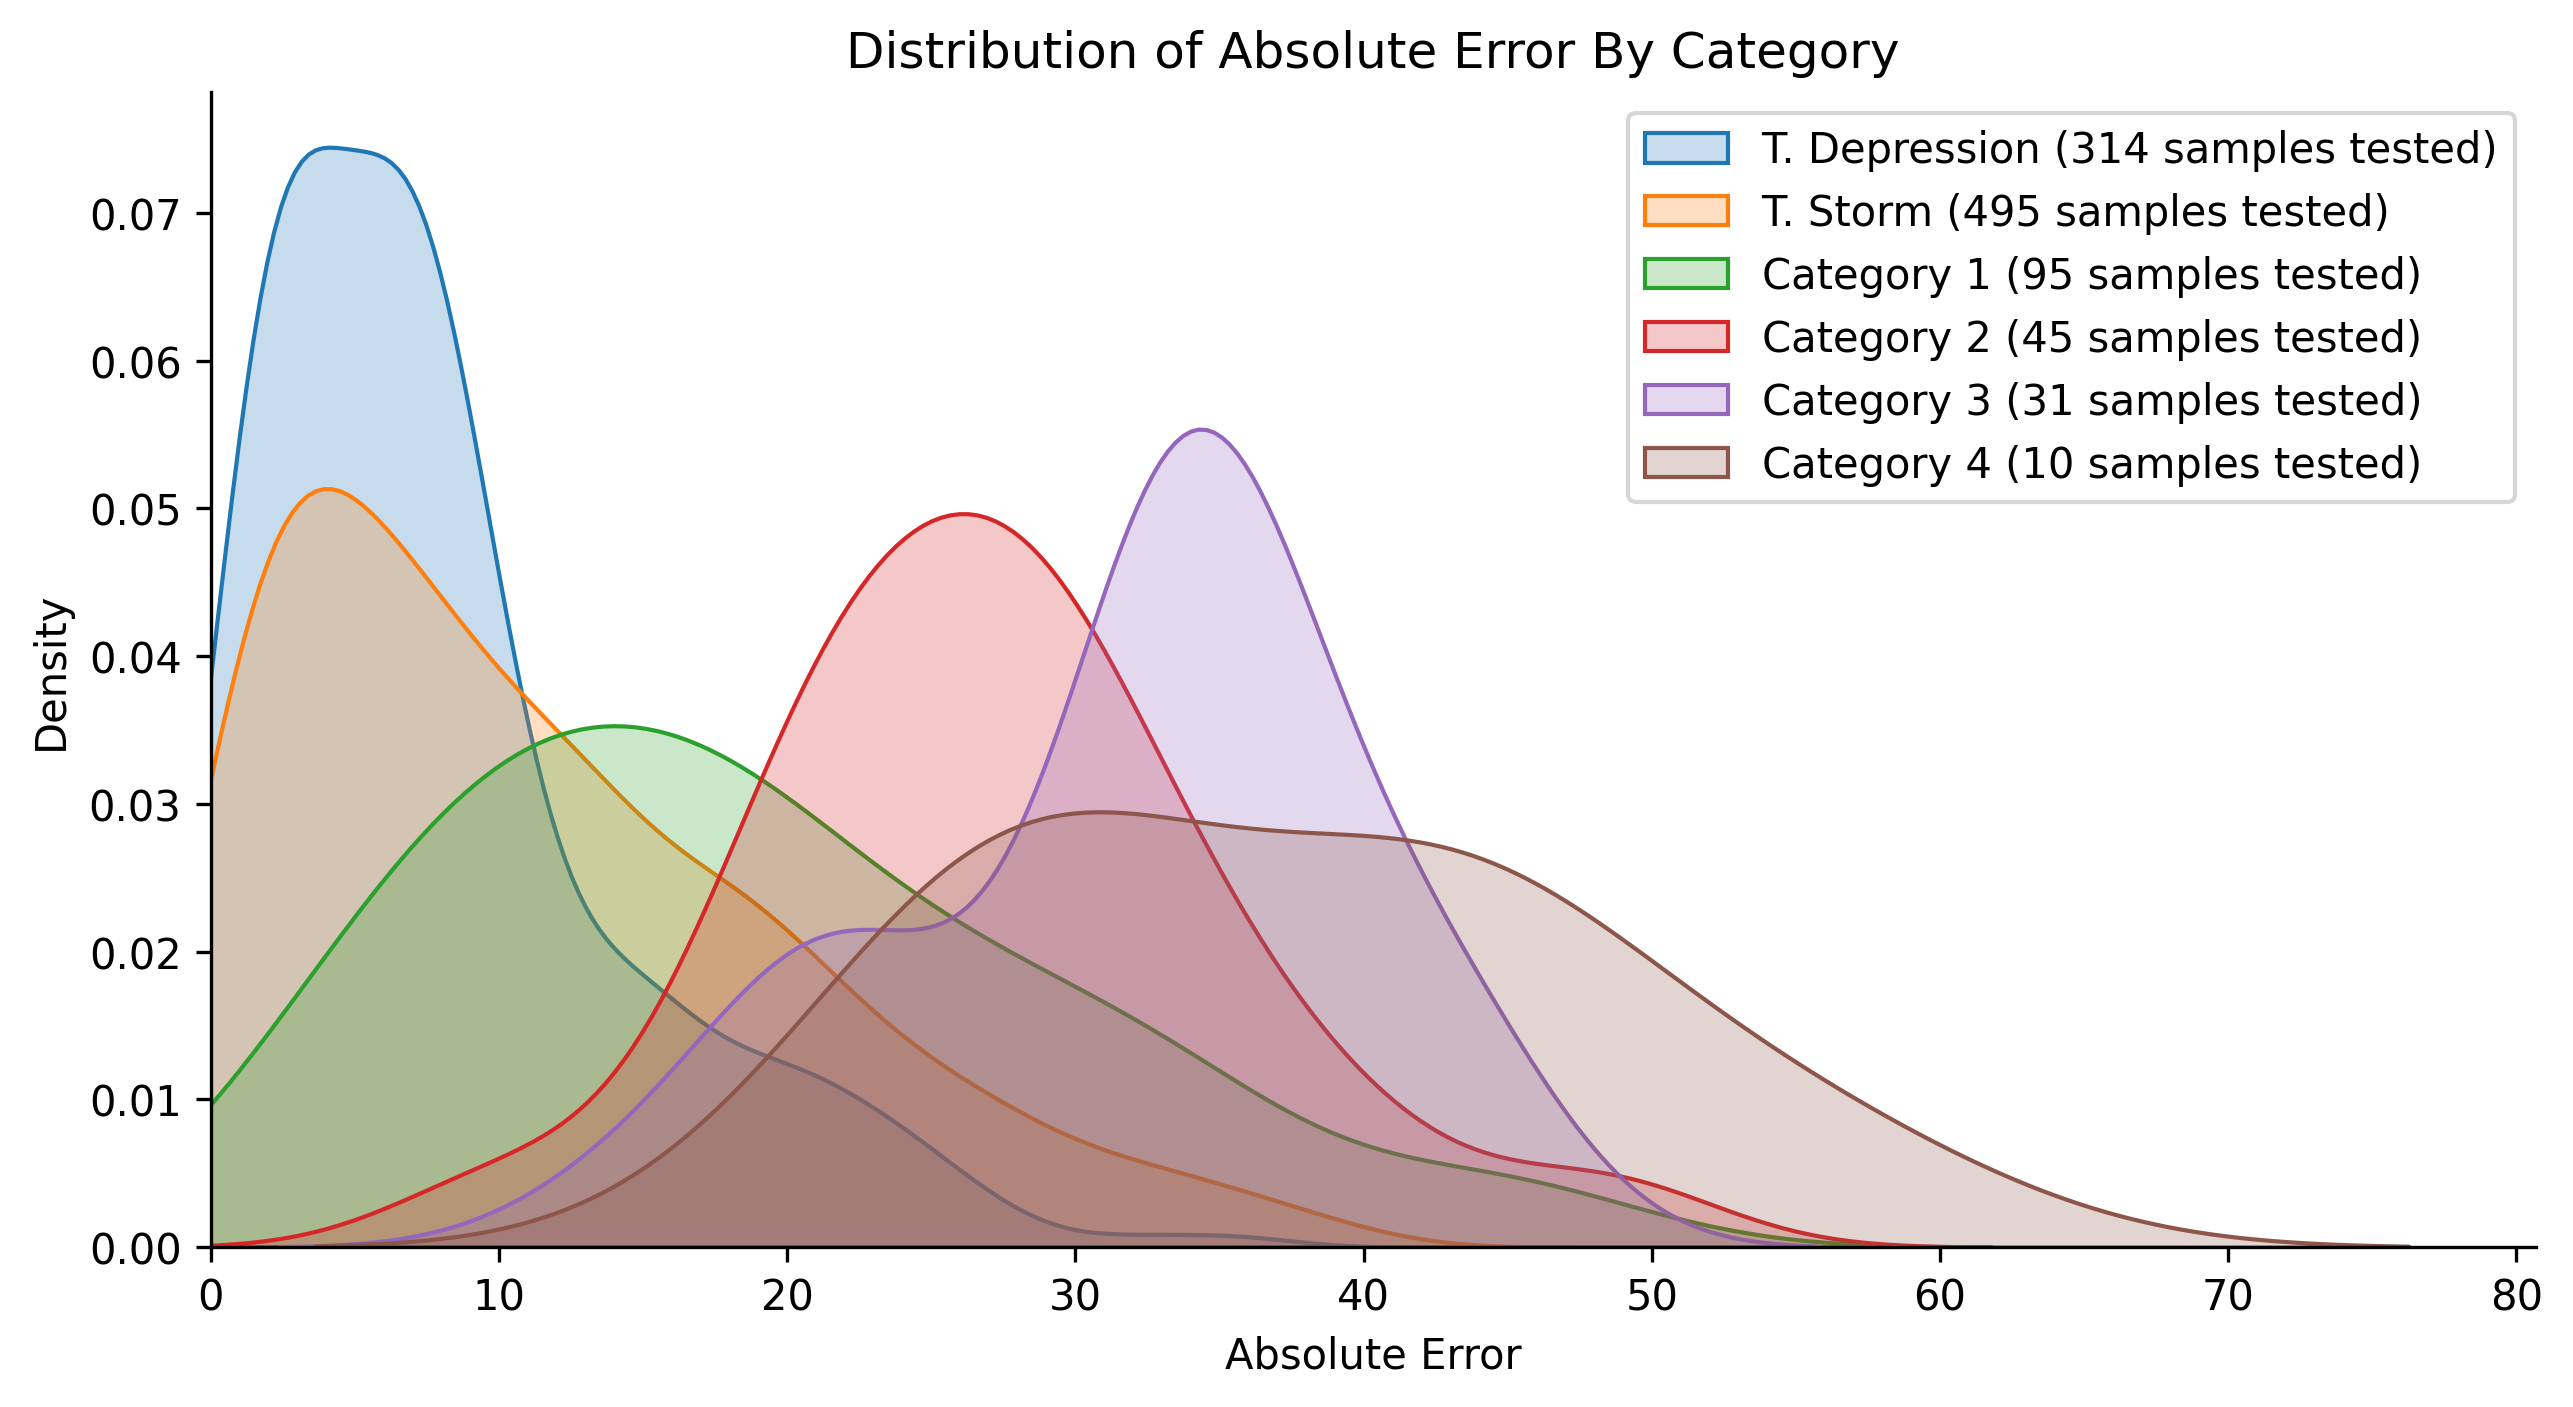

In [30]:
if __name__ == "__main__":
    # Specify whether the script should use Keras's ImageDataGenerator to augment the training dataset. Assigning
    # this variable to True will improve accuracy, but will also increase execution time.
    AUGMENT = True

    # Specify how many folds in the k-fold validation process. Can be any integer greater than or equal to 2. Larger
    # integers will increase execution time.
    NUM_FOLDS = 5

    train_images, train_labels, test_images, test_labels = read_and_prepare_data('k_fold', NUM_FOLDS, augment=AUGMENT)
    model = build_model()
    predictions = pd.DataFrame(columns=['prediction', 'actual', 'abs_error', 'category'])

    
    Loss = []
    MAE = []
    RMSE = []
    
    for i in range(NUM_FOLDS):
        print('\n\nTraining Fold ' + str(i + 1) + ' of ' + str(NUM_FOLDS) + '\n')
        model = train_model(model, train_images[i], train_labels[i], test_images[i], test_labels[i])

        evaluate_and_save(model,i,test_images[i], test_labels[i])
        
        kth_fold_predictions = generate_predictions(model, test_images[i], test_labels[i])
        # save csv
        kth_fold_predictions.to_csv(str(i+1) + "_pred.csv")
        predictions = pd.concat([predictions, kth_fold_predictions],ignore_index=True)
        # predictions = predictions.concat(kth_fold_predictions, ignore_index=True)

    predictions.to_csv("all_pred.csv")
    show_validation_results(predictions)
    
    k_fold_result = {"k_fold":[1,2],"Loss":Loss,"MAE":MAE,"RMSE":RMSE}
    k_fold_result_df = pd.DataFrame(k_fold_result)
    k_fold_result_df.to_csv("k_fold_result.csv")
    for i in range(NUM_FOLDS):
        print("#"*7,"Fold {} Result".format(i+1),"#"*7)
        print('Test loss:', Loss[i],'Test MAE:', MAE[i],'Test RMSE:', RMSE[i])

In [28]:
predictions = pd.concat([predictions, kth_fold_predictions],ignore_index=True)